In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell
from common.calculate_variance import calculate_variance

import datetime as dt

InteractiveShell.ast_node_interactivity = "all"

In [187]:
# data 기초 전처리
data = pd.read_csv('../data/AAPL.csv')
data = data.set_index('Date')

# 인덱스를 datetime으로 변경
data.index = pd.to_datetime(data.index)

# test 셋과 train 셋으로 나누기
split_date= dt.datetime(2011,12,5)
train_data = data[data.index<split_date]
test_data = data[data.index>=split_date]

# log 수익률 column 추가
train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
train_data_return = train_data['log_price_return'].dropna()

test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)
test_data_return = test_data['log_price_return'].dropna()


/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_21268/1000520923.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_21268/1000520923.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)


In [188]:
# dataset 만들기
# train
train_data_set = pd.DataFrame()
var = calculate_variance(train_data_return)
train_data_set['rv'] = np.sqrt(var)
train_data_set['log_return'] = train_data_return
# test
test_data_set = pd.DataFrame()
var = calculate_variance(test_data_return)
test_data_set['rv'] = np.sqrt(var)
test_data_set['log_return'] = test_data_return


In [189]:
# scaling 
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_data_minmax = scaler_minmax.fit_transform(train_data_set)
test_data_minmax = scaler_minmax.transform(test_data_set)

# 정규화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_data_df = pd.DataFrame(train_data_minmax, index=train_data_set.index,columns=train_data_set.columns)
test_data_df = pd.DataFrame(test_data_minmax, index=test_data_set.index,columns=test_data_set.columns)

In [190]:
from garch.garch_mle import garch_mle
# from garch.garch import garch_mle


bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
#조건 alpha + beta < 1
LC = LinearConstraint([[0,1,1]], lb=0, ub=0.9999)

# DE 알고리즘을 사용한 파라미터 추정
result = differential_evolution(garch_mle, bounds=bounds, args=(train_data_set['log_return'],train_data_set['rv']), constraints=LC,
                                strategy='best1bin', maxiter=30, popsize=20, tol=1e-3, mutation=(0.3, 1),
                                recombination=0.7)

print("Optimized GARCH(1,1) Parameters:")
print(result.x)

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimized GARCH(1,1) Parameters:
[3.11295347e-04 1.20596894e-01 6.45130227e-01]


In [191]:
omega,alpha,beta = result.x
forecasts = np.zeros(len(test_data_set))
for t in range(1, len(test_data_set)):
    forecasts[t] = omega + alpha*test_data_set['log_return'][t-1]**2 + beta*test_data_set['rv'][t-1]**2

In [192]:
rv_train = pd.DataFrame(train_data_set['rv'])
scaler_garch = MinMaxScaler()
scaler_garch.fit(rv_train)

forecasts = np.sqrt(forecasts)
df = scaler_garch.transform(forecasts.reshape(-1,1))

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

(0.0, 0.045)

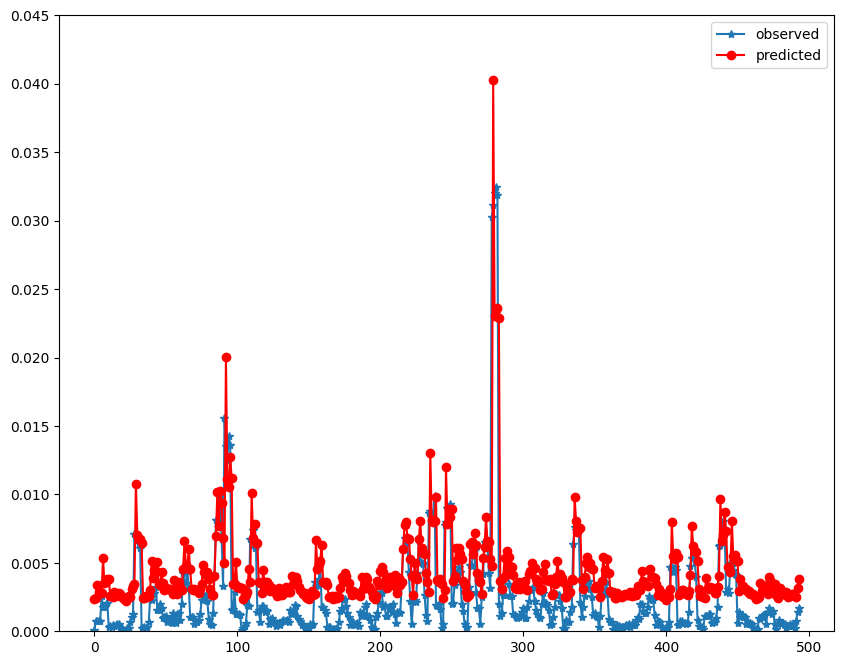

In [193]:
plt.figure(figsize=(10,8))
y = test_data_df['rv'].values
y_hat = df

plt.ylim([0,0.045])
plt.plot(y[1:]**2,marker='*', label='observed')
plt.plot(y_hat[1:]**2,marker='o', label = "predicted", color='red')


plt.legend()


<Figure size 1000x800 with 0 Axes>

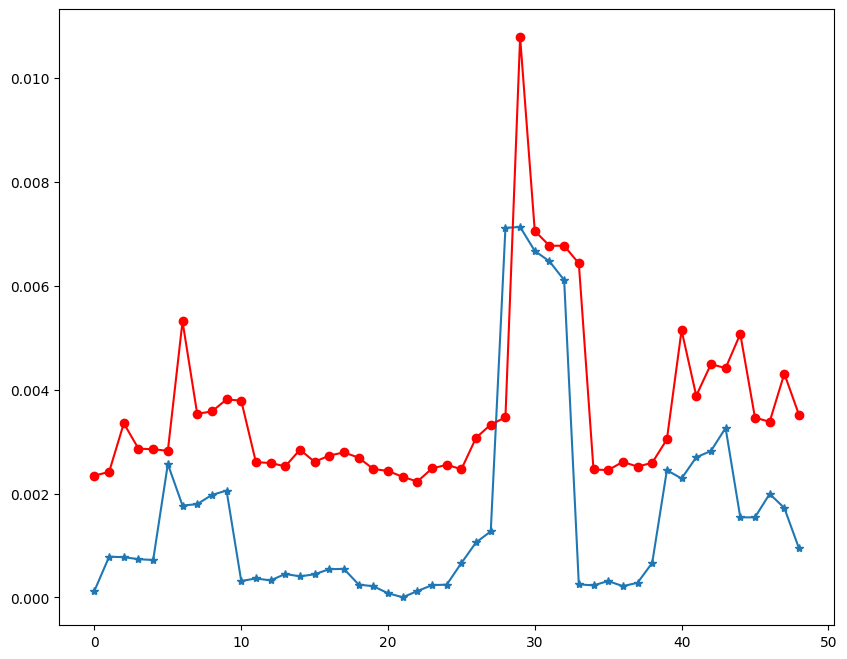

In [194]:
plt.figure(figsize=(10,8))
plt.plot(y[1:50]**2,marker='*', label='observed')
plt.plot(y_hat[1:50]**2,marker='o', label = "predicted", color='red')

In [195]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y[1:],y_hat[1:],squared=False)

0.026116623151995356